# Linear models

## Preprocessing 

This work will be done with Online News Popularity dataset. Let's start with importing required libraries and take a bdief look of dataset.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 

df = pd.read_csv("C:\ONU EDU\ML\Linear_models\OnlineNewsPopularityReduced.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            4954 non-null   object 
 1   timedelta                      4954 non-null   int64  
 2   n_tokens_title                 4954 non-null   int64  
 3   n_tokens_content               4954 non-null   int64  
 4   n_unique_tokens                4954 non-null   float64
 5   n_non_stop_words               4954 non-null   float64
 6   n_non_stop_unique_tokens       4954 non-null   float64
 7   num_hrefs                      4954 non-null   int64  
 8   num_self_hrefs                 4954 non-null   int64  
 9   num_imgs                       4954 non-null   int64  
 10  num_videos                     4954 non-null   int64  
 11  average_token_length           4954 non-null   float64
 12  num_keywords                   4954 non-null   i

As we can see all data in the dataset is already numeric, except for the first "URL" column, but the link does not affect the popularity of the article in any way. So, you can simply remove it, then if necessary, you can easily find the link to the article by the row id.

Also deeper analysis of dataset has shown that the in "kw_min_min" column all values are equal to -1, so we don't need it.

In [3]:
df = df.drop("url", axis=1)
df = df.drop("kw_min_min", axis=1)

Now let's get down to the target and it's distribution

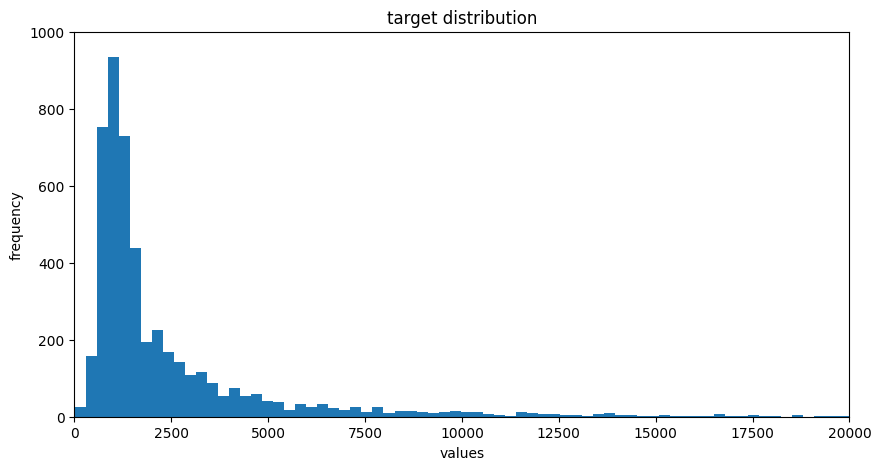

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(df["shares"], bins=1000)
ax.set_xlabel("values")
ax.set_ylabel("frequency")
ax.set_title("target distribution")

ax.set_xlim(0, 20000)
ax.set_ylim(0, 1000)

plt.show()

As we can see this distribution is far cry from normal distribution and looks more like log-normal or exp distribution. So I decided to use numpy.log function, it can make distribution more appealing.

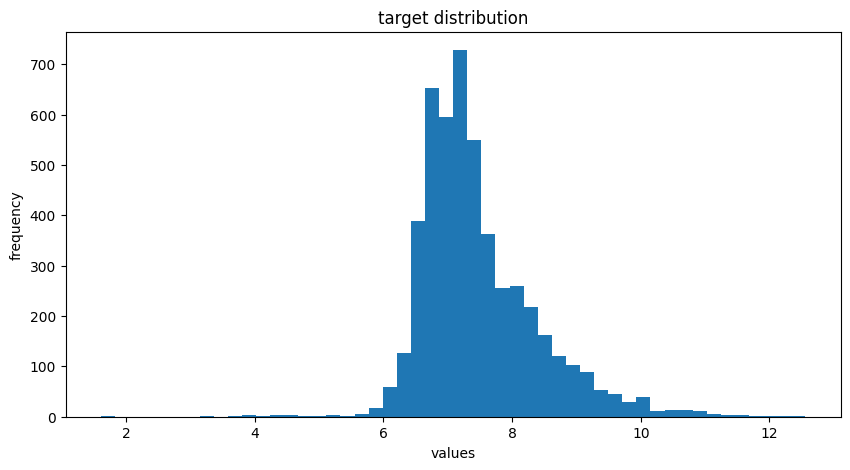

In [5]:
df['shares'] = np.log(df['shares'])

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df["shares"], bins=50)
ax.set_xlabel("values")
ax.set_ylabel("frequency")
ax.set_title("target distribution")
plt.show()

The result looks like normal distribution, so further calculations will be done on basis of that result.

Now time to move from regression model to classification, because previous expirience with that dataset has shown that it is not optimal to use regressor.

So the idea of classification is to make 3 groups based on our distribution, using mean and standart deviation.

In [6]:
mean_shares = np.mean(df['shares'])
std_shares = df['shares'].std()

category_1_upper = mean_shares - 0.5*std_shares
category_2_lower = mean_shares - 0.5*std_shares
category_2_upper = mean_shares + 0.5*std_shares
category_3_lower = mean_shares + 0.5*std_shares

conditions = [
    (df['shares'] < category_1_upper),
    (df['shares'] >= category_2_lower) & (df['shares'] <= category_2_upper),
    (df['shares'] > category_3_lower)
]

values = [1, 2, 3]

df['shares'] = np.select(conditions,values)
print(df['shares'].value_counts())


shares
1    1869
2    1851
3    1234
Name: count, dtype: int64


Alse let's scale our data to improve numerical stability and interpretability, it is not the most important part in logistic regressio, but it may improve result when there are outliers.

In [7]:
from sklearn.preprocessing import StandardScaler

X = df.drop('shares', axis=1)
y = df['shares']

scaler = StandardScaler()
X_st = scaler.fit_transform(X)

Move on to the splitting up the dataset into test and training sets.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_st, y, test_size=0.25, random_state=42)

## Modeling

We are going to use logistic regression in that case because we have classification problem and linear regression won't work.

In [9]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_valid)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_valid, y_pred))

0.4947538337368846


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('Precision:', precision_score(y_valid, y_pred, average = "weighted"))
print('Recall:', recall_score(y_valid, y_pred, average = "weighted"))
print('F1 score:', f1_score(y_valid, y_pred, average = "weighted"))

Precision: 0.48956207426233217
Recall: 0.4947538337368846
F1 score: 0.4875615271964214


The F1 score is a balanced combination of precision and recall so for further scoring we will use F1  

## Regularizations
We are going to compare 3 types of regularization and then tune their parameters to improve our model score

### L1 (Lasso)
let's start with default parameters and then move to parameters tuning

In [11]:
l1_reg = LogisticRegression(max_iter=1000, penalty="l1", solver = "liblinear")
l1_reg.fit(X_train, y_train)
y_pred = l1_reg.predict(X_valid)
print('F1 score:', f1_score(y_valid, y_pred, average = "weighted"))

F1 score: 0.4778545925959783


hyperparameters tuning

In [12]:
from sklearn.model_selection import GridSearchCV

l1_reg = LogisticRegression(max_iter = 1000, penalty="l1", solver = "liblinear")

params = {'C': np.logspace(-3, 3, 7)}

l1reg_grid = GridSearchCV(l1_reg, params, cv=5, scoring='f1_weighted', n_jobs=-1)
l1reg_grid.fit(X_train, y_train)

print(l1reg_grid.best_params_)
print(l1reg_grid.best_score_)

{'C': 0.1}
0.5109758545828311


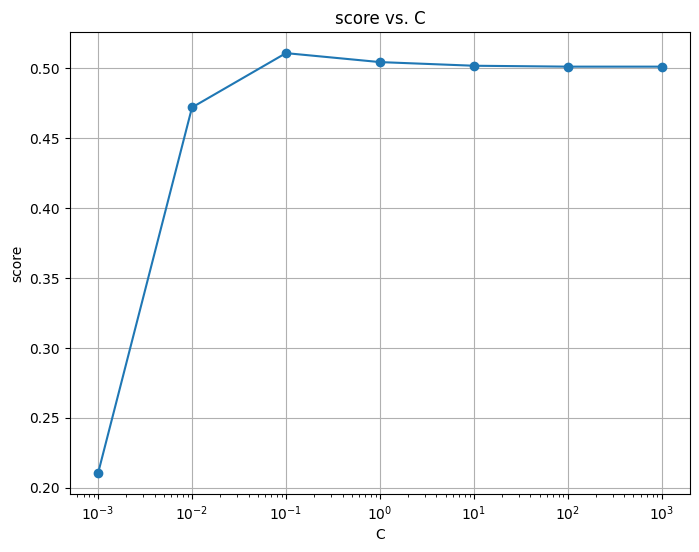

In [23]:
def draw(grid, param_name: str, start = 0, end = None, is_log = True, step = 1):
    
    param_values = grid.cv_results_[f'param_{param_name}'].data
    accuracy_scores = grid.cv_results_['mean_test_score']

    plt.figure(figsize=(8, 6))
    plt.plot(param_values[start:end:step], accuracy_scores[start:end:step], marker='o')

    if (is_log == True):
        plt.xscale('log')

    plt.title(f'score vs. {param_name}')
    plt.xlabel(f'{param_name}')
    plt.ylabel('score')
    plt.grid(True)
    plt.show()

draw(l1reg_grid, "C")

### L2 (Ridge)
default

In [24]:
l2_reg = LogisticRegression(max_iter=1000, penalty="l2", solver = "lbfgs", C=1.0)
l2_reg.fit(X_train, y_train)
y_pred = l2_reg.predict(X_valid)
print('F1 score:', f1_score(y_valid, y_pred, average = "weighted"))

F1 score: 0.4875615271964214


hyperparameters tuning

In [25]:
l2_reg = LogisticRegression(max_iter=1000, penalty="l2", solver = "lbfgs")

params = {'C': np.logspace(-3, 3, 7)}

l2reg_grid = GridSearchCV(l2_reg, params, cv=5, scoring='f1_weighted', n_jobs=-1)
l2reg_grid.fit(X_train, y_train)

print(l2reg_grid.best_params_)
print(l2reg_grid.best_score_)

{'C': 0.01}
0.5052171936898643


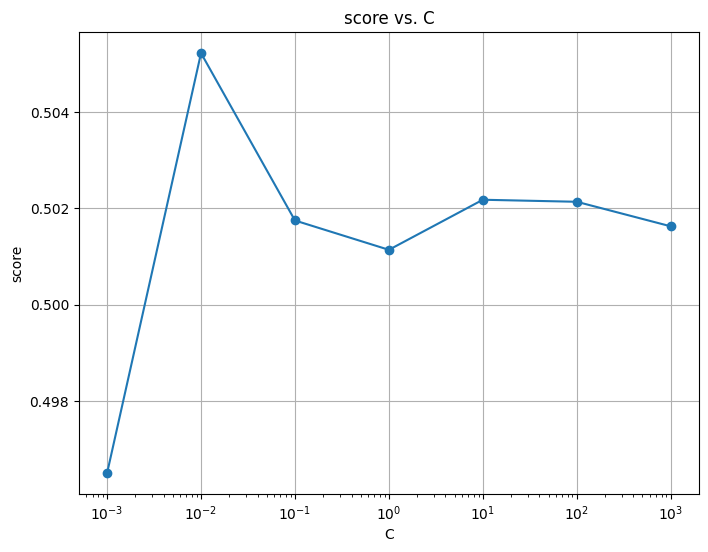

In [26]:
draw(l2reg_grid, "C")

### Elastic Net 
default

In [27]:
elnet_reg = LogisticRegression(max_iter=1000, penalty="elasticnet", solver = "saga", l1_ratio=0.5, C=1.0, n_jobs=-1)
elnet_reg.fit(X_train, y_train)
y_pred = elnet_reg.predict(X_valid)
print('F1 score:', f1_score(y_valid, y_pred, average = "weighted"))

F1 score: 0.4841195880128741


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


hyperparameters tuning

In [28]:
elen_reg = LogisticRegression(max_iter=1000, penalty="elasticnet", solver = "saga", n_jobs=-1)

params = {'C': np.logspace(-3, 3, 7), "l1_ratio": np.arange(0.1, 1, 0.1)}

elenreg_grid = GridSearchCV(elen_reg, params, cv=5, scoring='f1_weighted', n_jobs=-1)
elenreg_grid.fit(X_train, y_train)

print(elenreg_grid.best_params_)
print(elenreg_grid.best_score_)

{'C': 0.01, 'l1_ratio': 0.2}
0.5092894713962862


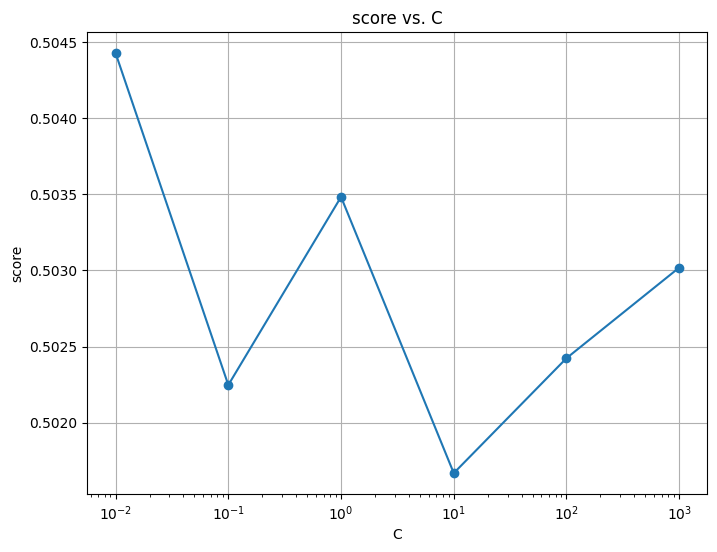

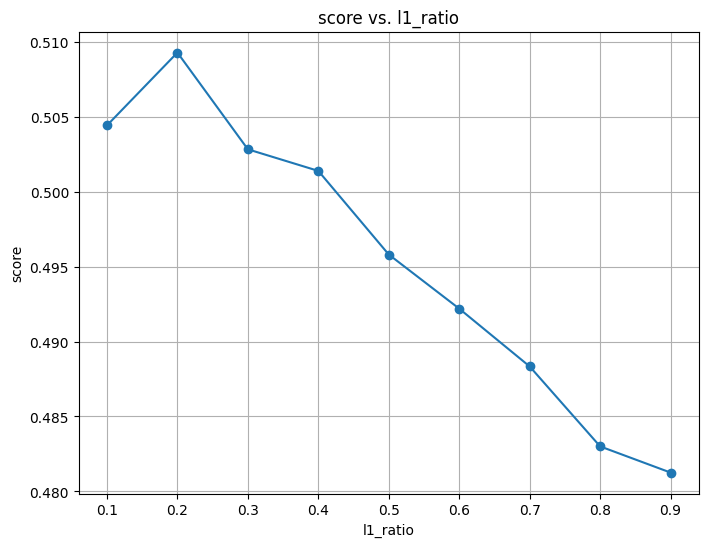

In [29]:
draw(elenreg_grid, "C", 9, 63, True, 9)
draw(elenreg_grid, "l1_ratio", 9, 18, False)


According to the F1 score we can see that all model have slightly improved.

## Conclusion

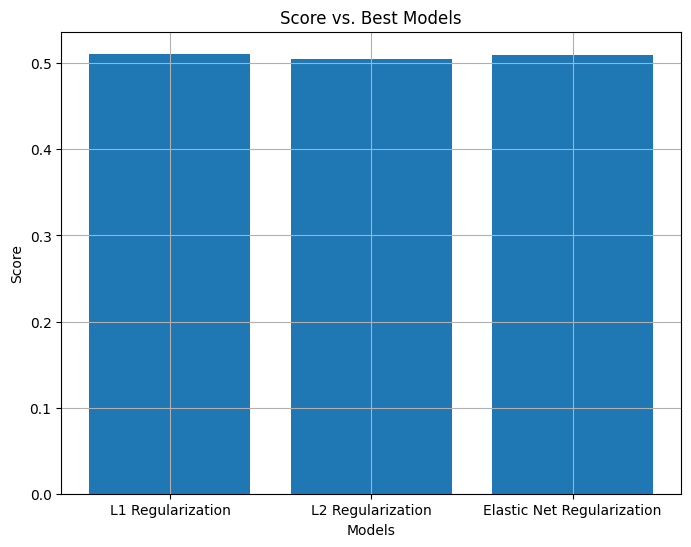

L1 Regularization = 0.5109758545828311
L2 Regularization = 0.5052171936898643
Elastic Net Regularization = 0.5092894713962862


In [30]:
best_scores = [l1reg_grid.best_score_, l2reg_grid.best_score_, elenreg_grid.best_score_]
model_names = ['L1 Regularization', 'L2 Regularization', 'Elastic Net Regularization']

plt.figure(figsize=(8, 6))
plt.bar(model_names, best_scores)
plt.title('Score vs. Best Models')
plt.xlabel('Models')
plt.ylabel('Score')
plt.grid(True)
plt.show()

for i in range(len(best_scores)):
    print(f"{model_names[i]} = {best_scores[i]}")

As we can see the difference between models is insignificant and equals less than 0.5%. So if we want to choose the best way to use linear regression, we should also take an execution time into account. The best time has L2, second is L1 and the last one is Elastic net and it is obvious because it uses both L1 and L2.

In [35]:
coefficients = elenreg_grid.best_estimator_.coef_
intercept = elenreg_grid.best_estimator_.intercept_

coef_df = pd.DataFrame({'Feature': ['Intercept'] + [f'Feature {i+1}' for i in range(len(coefficients))],
                        'Coefficient': [intercept] + coefficients.tolist()})

# Display the coefficients
print(coef_df)

     Feature                                        Coefficient
0  Intercept  [0.1314951178875995, 0.20614414895196723, -0.3...
1  Feature 1  [-0.09408735387306483, 0.0, 0.0, 0.0, 0.0, 0.0...
2  Feature 2  [0.0, 0.01949294280136164, 0.0, 0.0, 0.0, 0.0,...
3  Feature 3  [0.26563627509016946, 0.0, 0.0, 0.0, 0.0, 0.0,...
